In [18]:
!pip install scikit-surprise

In [19]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
import itertools

In [24]:
# Try to read the CSV with error handling
try:
    train_df = pd.read_csv('/content/train.csv', on_bad_lines='warn', engine='python')
    # 'warn' will provide warnings for bad lines instead of crashing
except pd.errors.ParserError as e:
    print(f"An error occurred during CSV parsing: {e}")
    # Log more details about the error to figure out the problem lines
    # Example: Extract the bad lines and save them to a file for further investigation
    # If the file is very large, consider using a more memory-efficient approach to handle bad lines
    # and save the faulty lines to a new file
    with open("/content/bad_lines.csv", "w") as f:
      with open("/content/train.csv", "r") as csv_file:
        for line in csv_file:
          try:
            num_fields = len(line.strip().split(','))
            if num_fields != 15: #Change to the expected number of fields
              f.write(line)
          except:
            print(f"Unable to parse line: {line}")
            f.write(line)
    print('File output to /content/bad_lines.csv')

#Check if the data frame exists
if 'train_df' in locals():
    train_df.head()
    train_df.duplicated().sum()
    train_df.isnull().sum()
    train_df.dtypes
else:
    print("train_df not found, there was an issue with the csv file")

<ipython-input-24-8e64721145b1>:3: ParserWarning: Skipping line 15116: Expected 15 fields in line 15116, saw 21

  train_df = pd.read_csv('/content/train.csv', on_bad_lines='warn', engine='python')
<ipython-input-24-8e64721145b1>:3: ParserWarning: Skipping line 29477: Expected 15 fields in line 29477, saw 19

  train_df = pd.read_csv('/content/train.csv', on_bad_lines='warn', engine='python')
<ipython-input-24-8e64721145b1>:3: ParserWarning: Skipping line 87380: Expected 15 fields in line 87380, saw 16

  train_df = pd.read_csv('/content/train.csv', on_bad_lines='warn', engine='python')
<ipython-input-24-8e64721145b1>:3: ParserWarning: Skipping line 116641: Expected 15 fields in line 116641, saw 21

  train_df = pd.read_csv('/content/train.csv', on_bad_lines='warn', engine='python')
<ipython-input-24-8e64721145b1>:3: ParserWarning: Skipping line 206366: Expected 15 fields in line 206366, saw 25

  train_df = pd.read_csv('/content/train.csv', on_bad_lines='warn', engine='python')
<ipyth

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456868 entries, 0 to 1456867
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   genre_id         1456868 non-null  int64  
 1   ts_listen        1456867 non-null  float64
 2   media_id         1456866 non-null  float64
 3   album_id         1456866 non-null  float64
 4   context_type     1456865 non-null  float64
 5   release_date     1456862 non-null  float64
 6   platform_name    1456859 non-null  float64
 7   platform_family  1456858 non-null  float64
 8   media_duration   1456855 non-null  float64
 9   listen_type      1456851 non-null  float64
 10  user_gender      1456847 non-null  float64
 11  user_id          1456847 non-null  float64
 12  artist_id        1456841 non-null  float64
 13  user_age         1456833 non-null  float64
 14  is_listened      1456830 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 166.7 MB


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
count,1.456868e+06,1.456867e+06,1.456866e+06,1.456866e+06,1.456865e+06,1.456862e+06,1.456859e+06,1.456858e+06,1.456855e+06,1.456851e+06,1.456847e+06,1.456847e+06,1.456841e+06,1.456833e+06,1.456830e+06
mean,1.852458e+03,1.480080e+09,9.127234e+07,1.023186e+08,4.378953e+01,2.300279e+07,1.526019e+00,4.754949e+00,2.330019e+02,8.365183e+00,8.226272e+00,4.223331e+03,1.416625e+06,2.404884e+01,6.912323e-01
std,1.184621e+04,1.229742e+09,9.045280e+09,1.129505e+11,2.893039e+04,2.356979e+09,1.258983e+03,4.169146e+03,6.424664e+01,5.826610e+03,5.811484e+03,7.435989e+03,2.198384e+06,3.818912e+00,4.619852e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,1.478453e+09,1.461594e+07,1.335283e+06,0.000000e+00,2.009123e+07,0.000000e+00,0.000000e+00,1.970000e+02,0.000000e+00,0.000000e+00,9.480000e+02,3.771000e+03,2.100000e+01,0.000000e+00
50%,0.000000e+00,1.479036e+09,1.065065e+08,1.110727e+07,1.000000e+00,2.015041e+07,0.000000e+00,0.000000e+00,2.270000e+02,0.000000e+00,0.000000e+00,2.894000e+03,3.718430e+05,2.400000e+01,1.000000e+00
75%,2.500000e+01,1.479717e+09,1.321236e+08,1.403823e+07,2.000000e+00,2.016083e+07,1.000000e+00,0.000000e+00,2.550000e+02,1.000000e+00,1.000000e+00,6.380000e+03,1.519461e+06,2.700000e+01,1.000000e+00
max,2.545410e+05,1.478457e+12,1.091762e+13,1.363321e+14,2.016072e+07,2.013071e+12,1.519461e+06,4.790926e+06,8.216000e+03,5.542423e+06,5.542423e+06,7.508018e+06,1.143322e+07,3.000000e+01,1.000000e+00


In [27]:
num_unique_users = train_df['user_id'].nunique()
print(f"Total unique users: {num_unique_users}")
num_unique_artists = train_df['artist_id'].nunique()
print(f"Total unique artists: {num_unique_artists}")
num_unique_songs = train_df['media_id'].nunique()
print(f"Total unique songs: {num_unique_songs}")
num_unique_platforms = train_df['platform_name'].nunique()
print(f"Total unique platform: {num_unique_platforms}")

Total unique users: 18440
Total unique artists: 13313
Total unique songs: 45368
Total unique platform: 20



Age Statistics:
count    1.456833e+06
mean     2.404884e+01
std      3.818912e+00
min      1.000000e+00
25%      2.100000e+01
50%      2.400000e+01
75%      2.700000e+01
max      3.000000e+01
Name: user_age, dtype: float64

Age Group Percentages:
<20: 23.72%
20-25: 36.28%
25-30: 40.0%
30-35: 0.0%
35-40: 0.0%
40+: 0.0%


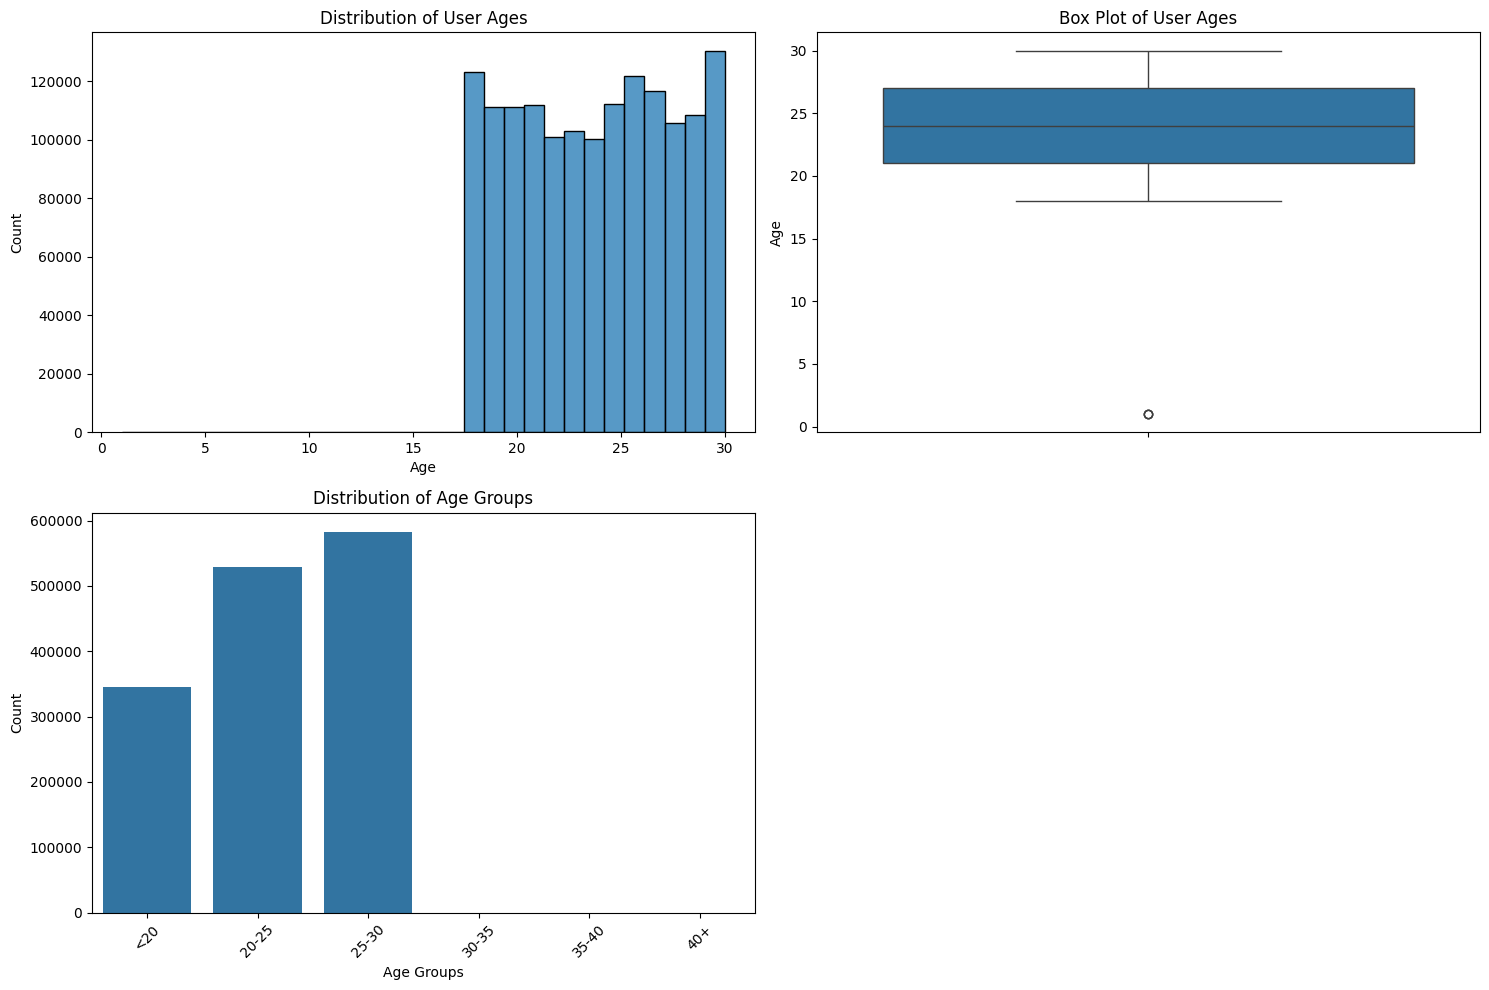


Additional Insights:
Median Age: 24.0
Mode Age: 30.0
Age Range: 1.0 to 30.0


In [31]:
# Create a figure with multiple subplots for different visualizations
plt.figure(figsize=(15, 10))

# Histogram of age distribution
plt.subplot(2, 2, 1)
sns.histplot(data=train_df, x='user_age', bins=30)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')

# Box plot for age distribution
plt.subplot(2, 2, 2)
sns.boxplot(y=train_df['user_age'])
plt.title('Box Plot of User Ages')
plt.ylabel('Age')

# Basic statistics
age_stats = train_df['user_age'].describe()
print("\nAge Statistics:")
print(age_stats)

# Age groups distribution
plt.subplot(2, 2, 3)
age_groups = pd.cut(train_df['user_age'],
                   bins=[0, 20, 25, 30, 35, 40, 100],
                   labels=['<20', '20-25', '25-30', '30-35', '35-40', '40+'])
age_group_counts = age_groups.value_counts().sort_index()
sns.barplot(x=age_group_counts.index, y=age_group_counts.values)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Calculate percentages for each age group
age_percentages = (age_group_counts / len(train_df) * 100).round(2)
print("\nAge Group Percentages:")
for age_group, percentage in age_percentages.items():
    print(f"{age_group}: {percentage}%")

# Adjust layout
plt.tight_layout()
plt.show()

# Additional insights
print("\nAdditional Insights:")
print(f"Median Age: {train_df['user_age'].median()}")
print(f"Mode Age: {train_df['user_age'].mode().values[0]}")
print(f"Age Range: {train_df['user_age'].min()} to {train_df['user_age'].max()}")

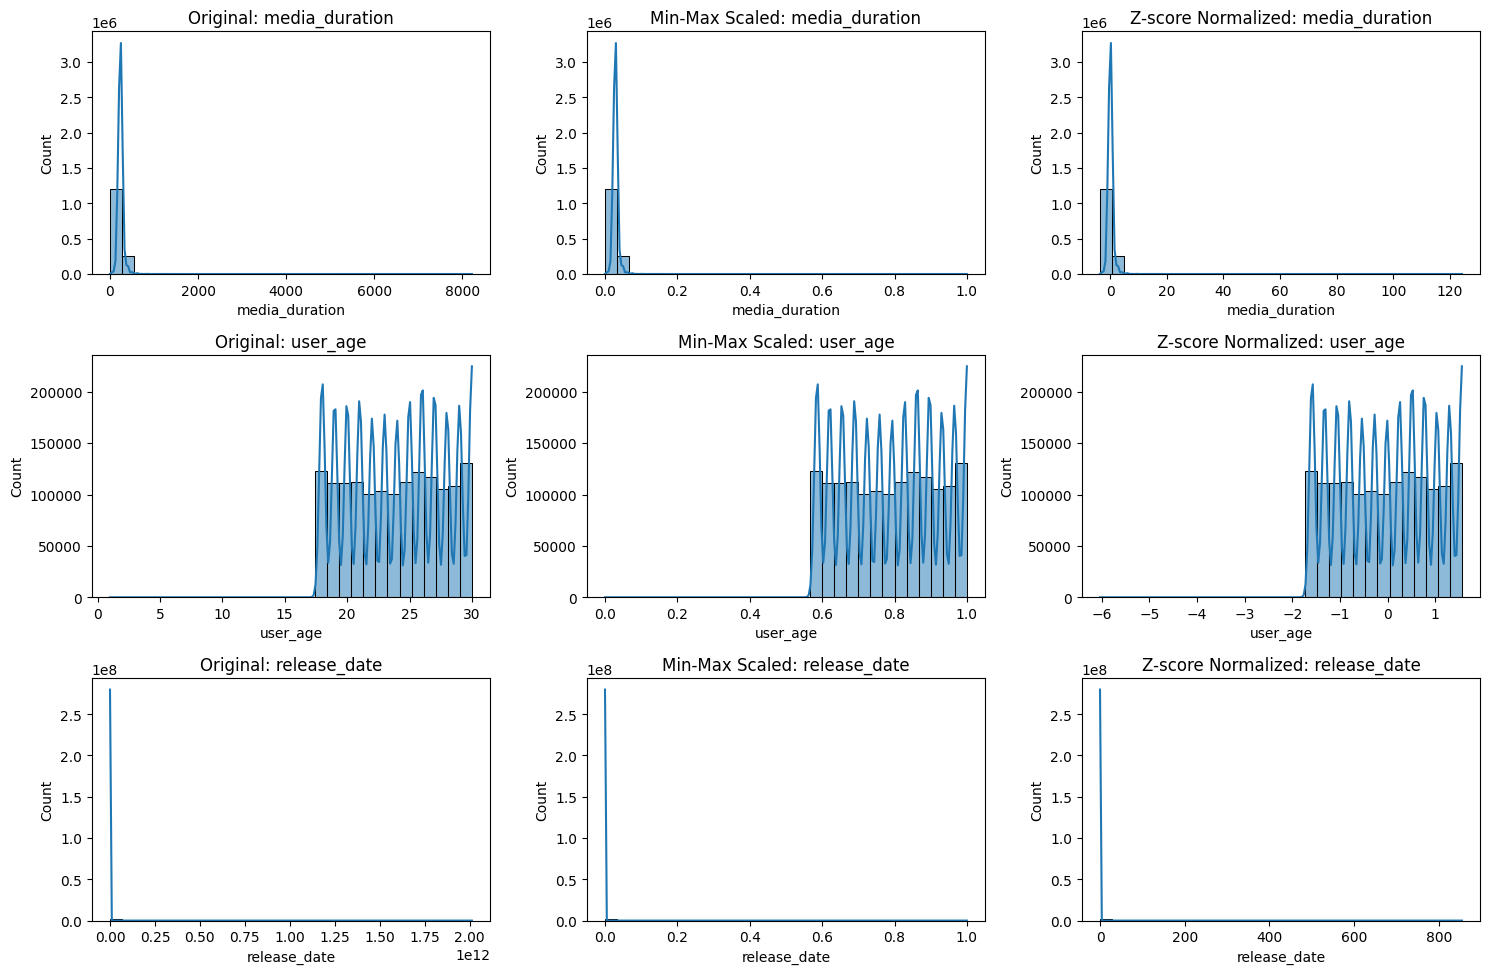

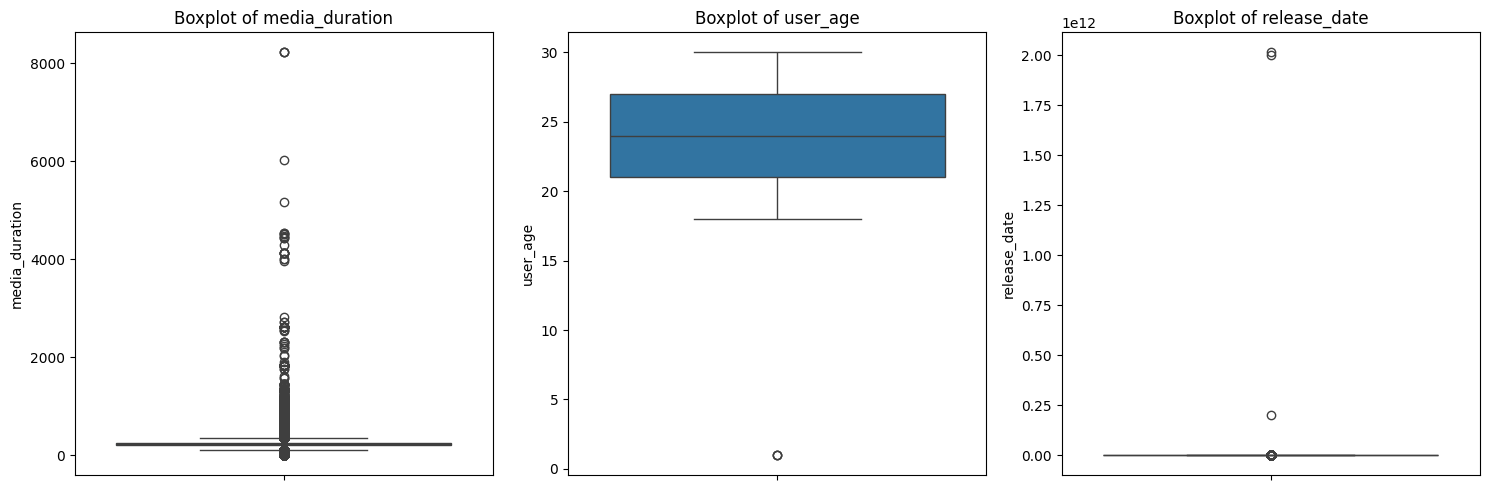

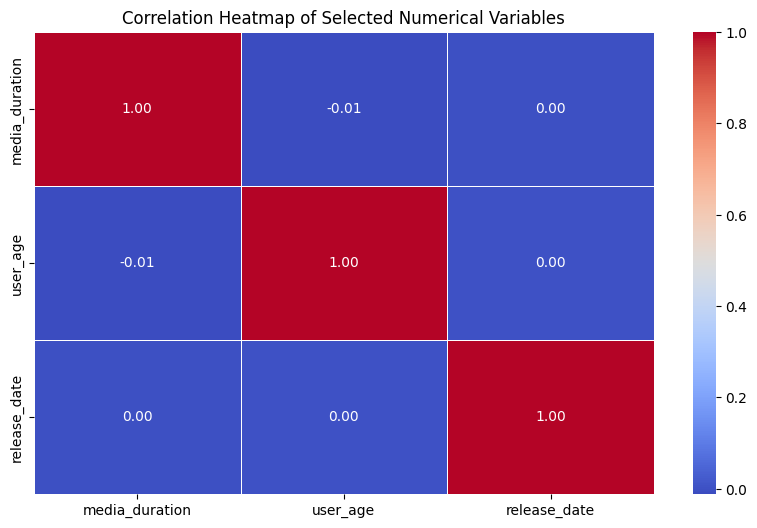

In [36]:
# Selecting numerical columns for normalization
num_cols = ["media_duration", "user_age", "release_date"]

# Applying Min-Max Scaling
scaler = MinMaxScaler()
df_minmax = train_df.copy() #Replace df with train_df
df_minmax[num_cols] = scaler.fit_transform(train_df[num_cols]) #Replace df with train_df

# Applying Standardization (Z-score normalization)
scaler = StandardScaler()
df_zscore = train_df.copy() #Replace df with train_df
df_zscore[num_cols] = scaler.fit_transform(train_df[num_cols]) #Replace df with train_df

# Plot histograms before and after normalization
figure, axes = plt.subplots(3, 3, figsize=(15, 10)) #Replaced plt with figure

for i, col in enumerate(num_cols):
    # Original Distribution
    sns.histplot(train_df[col], bins=30, kde=True, ax=axes[i, 0]) #Replace df with train_df
    axes[i, 0].set_title(f"Original: {col}")

    # Min-Max Scaled
    sns.histplot(df_minmax[col], bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Min-Max Scaled: {col}")

    # Z-score Normalized
    sns.histplot(df_zscore[col], bins=30, kde=True, ax=axes[i, 2])
    axes[i, 2].set_title(f"Z-score Normalized: {col}")

plt.tight_layout()
plt.show()

# Box plots to detect outliers
figure, axes = plt.subplots(1, 3, figsize=(15, 5)) #Replaced plt with figure

for i, col in enumerate(num_cols):
    sns.boxplot(y=train_df[col], ax=axes[i]) #Replace df with train_df
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

# Correlation heatmap
figure = plt.figure(figsize=(10, 6))#Replaced plt with figure
sns.heatmap(train_df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5) #Replace df with train_df
plt.title("Correlation Heatmap of Selected Numerical Variables")
plt.show()


In [37]:
# For simplicity, assuming every listen is a positive interaction with a rating of 1
train_df['rating'] = 1
# Create a Surprise dataset
reader = Reader(rating_scale=(0, 1))  # Define the rating scale
data = Dataset.load_from_df(train_df[['user_id', 'media_id', 'rating']], reader)

# Split the dataset into the train and test set
trainset, testset = train_test_split(data, test_size=0.2)

In [33]:
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import cross_validate

def load_data(file_path):
    df = train_df.copy()

    # Creating an implicit rating system based on listen_type and media_duration
    df['rating'] = df['listen_type'] + (df['media_duration'] / df['media_duration'].max())

    reader = Reader(rating_scale=(0, 5))
    data = Dataset.load_from_df(df[['user_id', 'media_id', 'rating']], reader)
    return data, df
# Matrix factorization
def train_model(data):
    algo = SVDpp()

    # Training on the User-Item Matrix
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    return algo

def get_top_n_recommendations(algo, df, user_id, n=5):
    unique_items = df['media_id'].unique()
    user_rated_items = df[df['user_id'] == user_id]['media_id'].tolist()
    # Making prediction
    items_to_predict = [item for item in unique_items if item not in user_rated_items]
    predictions = [(item, algo.predict(user_id, item).est) for item in items_to_predict]

    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    return top_n

def main():
    file_path = '/content/train.csv'
    data, df = load_data(file_path)
    algo = train_model(data)

    # Get top 5 recommendations for user 1
    user_id = 1
    top_n = get_top_n_recommendations(algo, df, user_id, n=5)
    print(f'Top {len(top_n)} recommendations for user {user_id}:')
    for item, rating in top_n:
        print(f'Media {item} with predicted rating {rating:.2f}')

if __name__ == '__main__':
    main()

Top 5 recommendations for user 1:
Media 222606.0 with predicted rating 5.00
Media 250467.0 with predicted rating 5.00
Media 305197.0 with predicted rating 5.00
Media 900502.0 with predicted rating 5.00
Media 542335.0 with predicted rating 5.00


# F-score

In [ ]:
from surprise import Dataset, Reader, SVDpp, accuracy
from surprise.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def calculate_f_score(algo, test_set, threshold=3.5):
    """
    Calculate precision, recall, and F-score for the recommender system.

    Args:
        algo: Trained SVDpp algorithm
        test_set: Test set from surprise library
        threshold: Rating threshold to consider an item as relevant (default: 3.5)

    Returns:
        tuple: (precision, recall, f1_score)
    """
    # Lists to store true and predicted ratings
    y_true = []
    y_pred = []

    # Generate predictions for test set
    for uid, iid, true_r in test_set:
        pred = algo.predict(uid, iid)

        # Convert ratings to binary (relevant/not relevant)
        y_true.append(1 if true_r >= threshold else 0)
        y_pred.append(1 if pred.est >= threshold else 0)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                             average='binary',
                                                             zero_division=0)

    return precision, recall, f1

def evaluate_recommender(data, n_folds=5):
    """
    Evaluate the recommender system using cross-validation.

    Args:
        data: Surprise dataset object
        n_folds: Number of folds for cross-validation (default: 5)

    Returns:
        dict: Dictionary containing average metrics
    """
    # Lists to store metrics for each fold
    precisions = []
    recalls = []
    f1_scores = []

    kf = KFold(n_splits=n_folds) # We define the kfold here.
    # Perform cross-validation
    for fold_idx, (trainset, testset) in enumerate(kf.split(data)): #We use kf to do cross-validation
        # Train the algorithm
        algo = SVDpp()
        algo.fit(trainset)

        # Calculate metrics for this fold
        # Prepare the testset for the metrics calculation, this is a list of tuples
        testset_for_metrics = [(uid, iid, true_r) for (uid, iid, true_r) in testset]
        precision, recall, f1 = calculate_f_score(algo, testset_for_metrics)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"Fold {fold_idx + 1}:")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}\n")

    # Calculate average metrics
    metrics = {
        'avg_precision': np.mean(precisions),
        'avg_recall': np.mean(recalls),
        'avg_f1': np.mean(f1_scores),
        'std_precision': np.std(precisions),
        'std_recall': np.std(recalls),
        'std_f1': np.std(f1_scores)
    }

    return metrics

# Modified main function to include evaluation
def main():
    file_path = '/content/train.csv'
    data, df = load_data(file_path)

    # Evaluate the recommender system
    print("Evaluating recommender system...")
    metrics = evaluate_recommender(data)

    print("\nOverall Performance:")
    print(f"Average Precision: {metrics['avg_precision']:.3f} ± {metrics['std_precision']:.3f}")
    print(f"Average Recall: {metrics['avg_recall']:.3f} ± {metrics['std_recall']:.3f}")
    print(f"Average F1-score: {metrics['avg_f1']:.3f} ± {metrics['std_f1']:.3f}")

    # Train final model and get recommendations
    algo = train_model(data)
    user_id = 1
    top_n = get_top_n_recommendations(algo, df, user_id, n=5)

    print(f'\nTop {len(top_n)} recommendations for user {user_id}:')
    for item, rating in top_n:
        print(f'Media {item} with predicted rating {rating:.2f}')

if __name__ == '__main__':
    main()

Evaluating recommender system...
Fold 1:
Precision: 0.000
Recall: 1.000
F1-score: 0.000

Fold 2:
Precision: 0.000
Recall: 1.000
F1-score: 0.000

